In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns

In [2]:
linemen = pd.read_csv('sis_ol_run.csv')
rbs = pd.read_csv('sis_rb_rushing.csv')
qbs = pd.read_csv('sis_qb_rushing.csv')

In [3]:
pbp = pd.concat([pd.read_csv(f'pbp_data/play_by_play_{season}.csv.gz', compression='gzip', low_memory=False) for season in range(2016,2021)])

In [4]:
rbs['attempts'] = rbs['insideAtt'] + rbs['offTackleAtt'] + rbs['outsideAtt']
qbs['attempts'] = qbs['insideAtt'] + rbs['offTackleAtt'] + rbs['outsideAtt']
teams = linemen.groupby(['season', 'team']).agg({'pointsEarned':'sum'}).rename(columns={'pointsEarned':'ol_points'})
teams['rb_points'] = rbs.groupby(['season', 'team']).agg({'rushPointsEarned':'sum'})
teams['rb_runs'] = rbs.groupby(['season', 'team']).agg({'attempts':'sum'})
teams['rb_eff'] = teams['rb_points']/teams['rb_runs']
teams['ol_eff'] = teams['ol_points']/teams['rb_runs']

team_names = {
    'Chiefs':'KC',
    'Packers':'GB',
    'Texans':'HOU',
    'Buccaneers':'TB',
    'Seahawks':'SEA',
    'Bills':'BUF',
    'Titans':'TEN',
    'Colts':'IND',
    'Raiders':'LV',
    'Panthers':'CAR',
    'Falcons':'ATL',
    'Steelers':'PIT',
    'Chargers':'LAC',
    'Lions':'DET',
    'Vikings':'MIN',
    'Saints':'NO',
    'Browns':'CLE',
    'Cardinals':'ARI',
    'Rams':'LA',
    'Bengals':'CIN',
    'Dolphins':'MIA',
    'Jaguars':'JAX',
    'Giants':'NYG',
    'Broncos':'DEN',
    'Cowboys':'DAL',
    '49ers':'SF',
    'Football Team':'WAS',
    'Redskins':'WAS', # for pre-2020 data :(
    'Patriots':'NE',
    'Ravens':'BAL',
    'Bears':'CHI',
    'Jets':'NYJ',
    'Eagles':'PHI'
}

teams.reset_index(inplace=True)
teams = teams.replace(team_names).rename(columns={'team':'posteam'}).set_index(['season', 'posteam'])

teams['rush_epa'] = pbp.loc[(pbp.play_type=='run') & (pbp.qb_scramble==0)].groupby(['season', 'posteam']).agg({'epa':'mean'})
teams = teams.reset_index()
teams.corr().iloc[1:,1:]

,ol_points,rb_points,rb_runs,rb_eff,ol_eff,rush_epa
ol_points,1.000000,0.314513,0.479056,0.290301,0.888659,0.705231
rb_points,0.314513,1.000000,0.393724,0.989607,0.165271,0.678976
rb_runs,0.479056,0.393724,1.000000,0.310967,0.033902,0.311334
rb_eff,0.290301,0.989607,0.310967,1.000000,0.182714,0.677293
ol_eff,0.888659,0.165271,0.033902,0.182714,1.000000,0.654277
rush_epa,0.705231,0.678976,0.311334,0.677293,0.654277,1.000000


In [5]:
eff_regression = sm.ols(formula="rush_epa ~ rb_eff + ol_eff", data=teams).fit()
eff_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               rush_epa   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     235.4
Date:                Tue, 02 Feb 2021   Prob (F-statistic):           5.64e-48
Time:                        21:28:27   Log-Likelihood:                 303.37
No. Observations:                 160   AIC:                            -600.7
Df Residuals:                     157   BIC:                            -591.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2820      0.013    -21.241      0.000      -0.308      -0.256
rb_eff         0.9100      0.064     14.214      0.000       0.784       1.036
ol_eff         0.9903      0.073     13.520      0.000       0.846       1.135
==============================================================================
Omnibus:                        0.609   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.738   Jarque-Bera (JB):                0.419
Skew:                           0.121   Prob(JB):                        0.811
Kurtosis:                       3.062   Cond. No.                         27.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
eff_regression.params

Intercept   -0.282004
rb_eff       0.909964
ol_eff       0.990309
dtype: float64

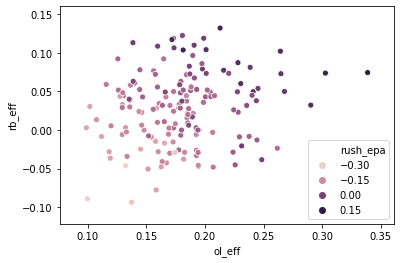

In [7]:
sns.scatterplot(x='ol_eff', y='rb_eff', hue='rush_epa', data=teams)